In [1]:
from astropy.io import fits
from astropy.wcs import wcs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab

In [132]:
def trans(i0,j0,file,Matr):
    value=0
    for i in range(i0-c,i0+c+1):
        for j in range(j0-c,j0+c+1):
            value+=file[0].data[i][j]*Matr[i-i0+c][j-j0+c]
    return value

def translation(file,Matrix):
    ResultMatrix=np.zeros((2*ObjectVol+1,2*ObjectVol+1))
    for i in range(i_borders[0],i_borders[1]+1):
        for j in range(j_borders[0],j_borders[1]+1):
            ResultMatrix[i-i_borders[0]][j-j_borders[0]]=trans(i,j,file,Matrix)
    #ResultMatrix*=FluxBefore/FluxAfter
    return ResultMatrix


def proc(E1,E2):
    file='id11_Coma_mapdld _'+str(E1)+'_'+str(E2)+'.fits'
    with fits.open(file, mode='update') as hdul:
        ResBeta=translation(hdul,BetaMatr)
        ResEqual=translation(hdul,EqualMatr)
    return ResBeta,ResEqual

def all_proc():
    ResBeta1727,ResEqual1727=proc(17,27)
    ResBeta2736,ResEqual2736=proc(27,36)
    ResBeta3650,ResEqual3650=proc(36,50)
    ResBeta50120,ResEqual50120=proc(50,120)
    write_to_file(ResBeta1727,'ResBeta1727')    
    write_to_file(ResEqual1727,'ResEqual1727')
    write_to_file(ResBeta2736,'ResBeta2736')
    write_to_file(ResEqual2736,'ResEqual2736')
    write_to_file(ResBeta3650,'ResBeta3650')
    write_to_file(ResEqual3650,'ResEqual3650')
    write_to_file(ResBeta50120,'ResBeta50120')
    write_to_file(ResEqual50120,'ResEqual50120')

In [133]:
def write_to_file(Matr,name):
    import re
    with open('./files/'+name, 'w') as fout:
        fout.write(u'#'+'\t'.join(str(e) for e in Matr.shape)+'\n')
        Matr.tofile(fout)

def read_from_file(name):
    import re
    with open('./files/'+name, 'rb') as f:
        line=f.readline().decode('ascii')
        if line.startswith('#'):
            shape=tuple(map(int, re.findall(r'(\d+)', line)))
        else:
            raise IOError('Failed to find shape in file') 
    
        result2=np.fromfile(f)
        result3=result2.reshape(shape)
    
    return result3

def all_read():
    ResBeta1727=read_from_file('ResBeta1727')
    ResEqual1727=read_from_file('ResEqual1727')
    ResBeta2736=read_from_file('ResBeta2736')
    ResEqual2736=read_from_file('ResEqual2736')
    ResBeta3650=read_from_file('ResBeta3650')
    ResEqual3650=read_from_file('ResEqual3650')
    ResBeta50120=read_from_file('ResBeta50120')
    ResEqual50120=read_from_file('ResEqual50120')
    return ResBeta1727,ResEqual1727,ResBeta2736,ResEqual2736,ResBeta3650,ResEqual3650,ResBeta50120,ResEqual50120

In [134]:
def read_errors(E1,E2):
    file='id11_Coma_mapdld _'+str(E1)+'_'+str(E2)+'.fits'
    with fits.open(file, mode='update') as hdul:
        ResultMatrix=np.zeros((2*ObjectVol+1,2*ObjectVol+1))
        for i in range(i_borders[0],i_borders[1]+1):
            for j in range(j_borders[0],j_borders[1]+1):
                ResultMatrix[i-i_borders[0]][j-j_borders[0]]=hdul[1].data[i][j]
    return ResultMatrix
    
def all_errors():
    errors1727=read_errors(17,27)
    errors2736=read_errors(27,36)
    errors3650=read_errors(36,50)
    errors50120=read_errors(50,120)
    return errors1727,errors2736,errors3650,errors50120

In [138]:
def Increase_Curve_Ob(i0,j0,file,Matr):
    radial=np.zeros(c+1)
    errors=np.zeros(c+1)
    counter=np.zeros(c+1)
    pix_size=4/60
    for i in range(0,Vol):
        for j in range(0,Vol):
            distance=np.sqrt((i-ObjectVol)**2+(j-ObjectVol)**2)
            if(distance<c+1):
                radial[int(distance)]+=Matr[i][j]
                errors[int(distance)]+=file[1].data[i0-ObjectVol+i][j0-ObjectVol+j]**2
                counter[int(distance)]+=1
    for i in range(1,c+1):
        radial[i]+=radial[i-1]
        counter[i]+=counter[i-1]
        errors[i]+=errors[i-1]
    errors=np.sqrt(errors)/counter
    #errors=np.sqrt(errors)
    return radial,errors


def Inc(ResBeta,ResEq,E1,E2,q,l1,l2,l3,l4,c1,c2):
    
    file='id11_Coma_mapdld _'+str(E1)+'_'+str(E2)+'.fits'
    with fits.open(file, mode='update') as hdul:
        radialBeta,errorsBeta =Increase_Curve_Ob(i_center,j_center,hdul,ResBeta)
        radialEq,errorsEq =Increase_Curve_Ob(i_center,j_center,hdul,ResEq)
        r4=range(0,4*len(radialEq),4)
        xerr4=4*(np.ones_like(radialEq))/2
        
        x_gaus=np.linspace(0,r4[-1],1000)
        y_gaus=np.zeros_like(x_gaus)
        y_beta=np.zeros_like(x_gaus)
        y_gaus=np.exp(-(x_gaus**2/(2*5**2)))*radialEq[0]
        y_beta=((1+(x_gaus/10.7)**2)**(-3*beta+0.5))*radialBeta[0]
    
        IncBeta=np.zeros_like(x_gaus)
        IncBeta[0]=y_beta[0]
        for i in range(0,len(y_beta)):
            IncBeta[i]=y_beta[i]*2*np.pi*x_gaus[i]
        for i in range(1,len(y_beta)):
            IncBeta[i]=y_beta[i]+IncBeta[i-1]
    
        IncGauss=np.zeros_like(x_gaus)
        IncGauss[0]=y_gaus[0]
        for i in range(0,len(y_beta)):
            IncGauss[i]=y_gaus[i]*2*np.pi*x_gaus[i]
        for i in range(1,len(y_beta)):
            IncGauss[i]=y_gaus[i]+IncGauss[i-1]
        
        if l1=='Eq':
            line1=plt.errorbar(r4[0:q], radialEq[0:q],xerr=xerr4[0:q],yerr=errorsEq[0:q],fmt='o',linewidth=0.5,mew=0,color="blue",label='Кривая роста')
            print('Eq',radialEq[0:q])
            print('errEq',errorsEq[0:q])
        if l2=='Beta':
            line2=plt.errorbar(r4[0:q], radialBeta[0:q],xerr=xerr4[0:q],yerr=errorsBeta[0:q],fmt='o',linewidth=0.5,mew=0,color="orange",label='IC'+r'$\beta$')
            print('Beta',radialBeta[0:q])
            print('errBeta',errorsBeta[0:q])
        if l3=='Gauss':
            line3, =plt.plot(x_gaus[0:int(q*1000/26)],IncGauss[0:int(q*1000/26)]*c1,label='PSF')
            print('PSF',IncGauss[0:int(q*1000/26):int(1000/26)]*c1)
        if l4=='Bm':
            line4, =plt.plot(x_gaus[0:int(q*1000/26)],IncBeta[0:int(q*1000/26)]*c2,label=r'$\beta$-модель')
            print('Beta-model',IncBeta[0:int(q*1000/26):int(1000/26)]*c2)
        plt.xlabel("Радиус, угл. мин.")
        plt.ylabel('Поток, мКраб')
        plt.legend(loc='lower right')
        #plt.gca().axis([0,80,0,90])
        #plt.savefig("Increase_curve_fin.jpg",dpi=1000)
        hdul.flush()
        hdul.close()


In [129]:
file='id11_Coma_mapdld _'+str(17)+'_'+str(27)+'.fits'
with fits.open(file, mode='update') as hdul:
    ErrMatrBeta=translation_err(hdul,BetaMatr)

In [125]:
def Im(ResEq,ResBeta,ResErrors,E1,E2):
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    f,axarr=plt.subplots(1,2,figsize=(10,10))
    left=axarr[0].imshow(ResEq,cmap='hot',interpolation='none',extent=[-60,60,-60,60])
    right=axarr[1].imshow(ResBeta,cmap='hot',interpolation='none',extent=[-60,60,-60,60])
    
    axarr[0].axes.get_yaxis().set_visible(False)
    axarr[1].axes.get_yaxis().set_visible(False)

    axarr[0].axes.set_xlabel("угл. мин.")
    axarr[1].axes.set_xlabel("угл. мин.")

    axarr[0].set_xticks([-60,-30,0,30, 60])
    axarr[1].set_xticks([-60,-30,0,30, 60])
    
    axarr[0].title.set_text('nonfolded'+' '+str(E1)+'-'+str(E2))
    axarr[1].title.set_text('folded'+' '+str(E1)+'-'+str(E2))
    
    divider0=make_axes_locatable(axarr[0])
    divider1=make_axes_locatable(axarr[1])
    cax0=divider0.append_axes("left",size="5%",pad=0.1)
    cax1=divider1.append_axes("right",size="5%",pad=0.1)
    cbl=f.colorbar(left,cax=cax0)
    cax0.yaxis.tick_left()
    #cbl.set_ticks([-1,0,1,2,3])
    #cax0.set_yticks([-1, 0, 2, 3])
    cbr=f.colorbar(right,cax=cax1)
    plt.show()
    
    
    low=plt.imshow(ResErrors,cmap='hot',interpolation='none',extent=[-60,60,-60,60])
    plt.gca().get_yaxis().set_visible(False)
    plt.title('errors')
    plt.colorbar()
    plt.show()
    #cbr.set_ticks([0,0.25,0.5,0.75,1])

In [46]:
def chi(arr1,err,arr2,C):
    return sum(((arr1-C*arr2)**2)/err**2)
def dchi(arr1,err,arr2,C):
    return sum(-2*arr2*(arr1-C*arr2)/err**2)
def lin_reg(arr1,err,arr2,C):
    con=chi(arr1,err,arr2,C)
    while con>0.0001:
        C=C-0.001*dchi(arr1,err,arr2,C)
        con=chi(arr1,err,arr2,C)
    return C

In [70]:
#data processing
#all_proc()

In [54]:
#read processed
ResBeta1727,ResEqual1727,ResBeta2736,ResEqual2736,ResBeta3650,ResEqual3650,ResBeta50120,ResEqual50120=all_read()

In [55]:
#read errors
errors1727,errors2736,errors3650,errors50120=all_errors()

Eq [ 3.1563437  21.33173263 46.31696661 64.30192454 74.61198711 83.86053437
 85.59299353 84.59180769 84.09301465 80.08406395 74.05171634 72.27759614
 77.76461671 79.0871171  81.08395887 80.70297251 76.29374165 77.29175209
 82.21987081 78.42425127 78.23206491 81.81001327 82.4231989  82.4484875
 80.53578371 84.21856384]
errEq [0.75977397 0.25344156 0.15205873 0.1133562  0.09156545 0.07285664
 0.0631705  0.05476255 0.04821583 0.04356977 0.03940349 0.03640728
 0.03347631 0.03084916 0.02883839 0.0270409  0.02554268 0.02402668
 0.02271243 0.02159433 0.02059694 0.01959571 0.01877384 0.01802797
 0.01731151 0.01673176]
Beta [ 1.05983504  8.88285339 21.60270447 33.65440737 43.96267674 54.95642368
 60.92907168 65.58360828 68.41325716 69.65647553 70.48007716 71.24682945
 72.477081   73.88868454 74.88292546 75.49705954 75.96010615 76.58988768
 77.16989776 77.85570598 78.32278405 78.74525599 78.99374655 78.85879357
 78.28987222 78.24793638]
errBeta [0.75977397 0.25344156 0.15205873 0.1133562  0.0915

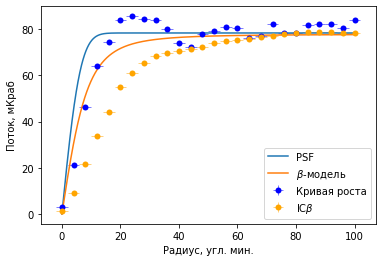

In [139]:
Inc(ResBeta1727,ResEqual1727,17,27,30,'Eq','Beta','Gauss','Bm',0.4,0.78)

Eq [ 1.7912488  11.35320425 18.00362554 22.75345093 26.62999799 27.19205015
 30.26676617 29.12203707 32.50808687 31.83245118 29.1507315  31.60958619
 36.25329108 29.40938762 26.95562239 29.24422638 29.87335839 30.31449329
 18.96491313 13.61527822 11.14141503 18.32176167 25.73369612 37.05648376
 41.42866034 39.15355618]
errEq [0.83814162 0.2795122  0.1677121  0.12501915 0.10098212 0.08034667
 0.06966466 0.06039052 0.05316999 0.04804484 0.04344889 0.04014363
 0.03691056 0.03401224 0.03179393 0.02981063 0.02815731 0.02648443
 0.02503401 0.0237997  0.0226986  0.02159338 0.02068606 0.01986241
 0.01907121 0.01842894]
Beta [ 0.44417762  3.58651929  8.27508477 12.45203043 15.97555823 19.65083427
 21.97149323 23.99890319 25.63215753 26.80997147 27.67376159 28.27064843
 28.67295193 28.32682713 27.91573602 27.3964651  26.57015031 25.09965554
 23.44981371 22.24570492 22.32738368 24.17883904 26.83387744 29.77786342
 32.06706682 33.87697771]
errBeta [0.83814162 0.2795122  0.1677121  0.12501915 0.100

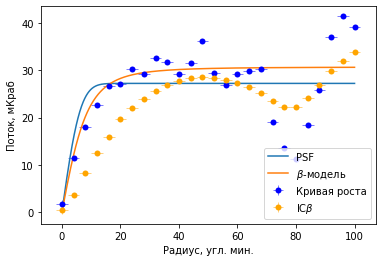

In [140]:
Inc(ResBeta2736,ResEqual2736,27,36,30,'Eq','Beta','Gauss','Bm',26.62999/108.78,26.6299/36.2751)

Beta [ 0.09909829  0.74281746  1.50367746  2.00149034  2.36710604  2.56467864
  2.76274902  2.59358945  2.22572641  2.1080708   2.41427657  3.0761011
  4.41859809  5.83923638  7.17900762  8.28631677  9.04152203  9.67726405
 10.24216879 10.49831596 10.72747828 10.04482209  8.03008933  4.72397874
  0.7333744  -1.95514853]
errBeta [0.91775149 0.30606227 0.1836369  0.13689213 0.11057233 0.08797837
 0.07628238 0.06612688 0.05822038 0.05260855 0.04757583 0.04395648
 0.04041637 0.03724268 0.03481364 0.03264196 0.03083164 0.02899986
 0.02741166 0.02606013 0.02485443 0.0236442  0.02265067 0.02174876
 0.02088238 0.02017863]
Beta-model [0.         1.10517584 1.87288557 2.31058176 2.54931584 2.6834295
 2.76274902 2.81219363 2.84450754 2.86650543 2.88201109 2.89326998
 2.90165597 2.90804079 2.91299563 2.91690552 2.92003657 2.92257688
 2.92466204 2.92639158 2.92783973 2.92906268 2.93010349 2.93099561
 2.93176526 2.93243324 2.93301621]


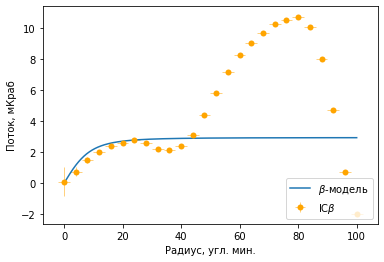

In [155]:
Inc(ResBeta3650,ResEqual3650,36,50,30,'Eq1','Beta','Gauss1','Bm',1,2.76274902/8.77074068)

Beta [ 0.05863905  0.47015133  1.04096194  1.5500515   2.03056846  2.41139785
  2.2046051   1.50874914  0.61063605 -0.35937318 -1.32924291 -2.08188098
 -2.94633954 -2.78537927 -2.69161068 -2.46980778 -2.72584082 -3.19914268
 -3.91567083 -4.16253428 -4.93587638 -5.99479546 -6.31928815 -5.50419078
 -2.9350214  -0.57551302]
errBeta [1.31827188 0.43964788 0.2637954  0.19664712 0.15883864 0.12638126
 0.10957943 0.09499087 0.08363328 0.07557132 0.06834136 0.0631418
 0.05805625 0.05349711 0.05000763 0.04688778 0.0442869  0.04165519
 0.0393733  0.03743146 0.03569902 0.03396011 0.03253249 0.03123647
 0.02999148 0.02897952]
Beta-model [0.         0.88190287 1.49451616 1.84378685 2.03429073 2.14131009
 2.2046051  2.24406067 2.26984637 2.28740014 2.29977327 2.30875759
 2.31544939 2.32054432 2.32449816 2.32761816 2.33011666 2.33214376
 2.33380767 2.3351878  2.33634339 2.33731927 2.33814981 2.33886169
 2.33947586 2.3400089  2.34047409]


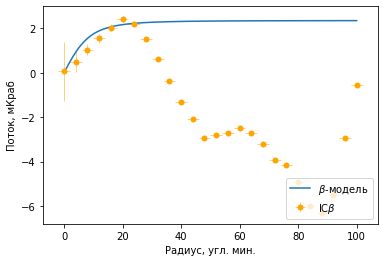

In [151]:
Inc(ResBeta50120,ResEqual50120,50,120,30,'Eq1','Beta','Gauss1','Bm',1,2.2046051/5.18987694)

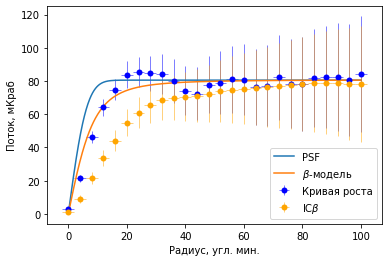

In [81]:
Inc(ResBeta1727,ResEqual1727,17,27,30,'Eq','Beta','Gauss','Bm')

Eq [ 1.7912488  11.35320425 18.00362554 22.75345093 26.62999799 27.19205015
 30.26676617 29.12203707 32.50808687 31.83245118 29.1507315  31.60958619
 36.25329108 29.40938762 26.95562239 29.24422638 29.87335839 30.31449329
 18.96491313 13.61527822 11.14141503 18.32176167 25.73369612 37.05648376
 41.42866034 39.15355618]
Beta [ 0.44417762  3.58651929  8.27508477 12.45203043 15.97555823 19.65083427
 21.97149323 23.99890319 25.63215753 26.80997147 27.67376159 28.27064843
 28.67295193 28.32682713 27.91573602 27.3964651  26.57015031 25.09965554
 23.44981371 22.24570492 22.32738368 24.17883904 26.83387744 29.77786342
 32.06706682 33.87697771]


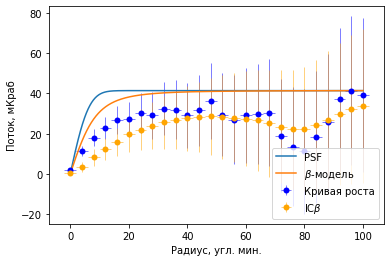

In [175]:
Inc(ResBeta2736,ResEqual2736,27,36,30,'Eq','Beta','Gauss','Bm')

Eq [ 8.71874630e-01  3.07265982e+00  4.69717933e+00  3.58501833e+00
  2.26430279e+00  3.44480972e+00  5.99183567e+00  4.08820315e+00
  1.44758809e+00 -2.06482105e+00  9.16967089e-01 -1.22570106e-02
  3.75133401e+00  9.92763422e+00  8.92130697e+00  8.98001615e+00
  1.55239423e+01  9.38282121e+00  1.31525720e+01  1.13096510e+01
  1.51491603e+01  2.10902860e+01  1.75421040e+01  9.59506054e+00
 -5.42004200e+00 -1.69360297e+01]
Beta [ 0.09909829  0.74281746  1.50367746  2.00149034  2.36710604  2.56467864
  2.76274902  2.59358945  2.22572641  2.1080708   2.41427657  3.0761011
  4.41859809  5.83923638  7.17900762  8.28631677  9.04152203  9.67726405
 10.24216879 10.49831596 10.72747828 10.04482209  8.03008933  4.72397874
  0.7333744  -1.95514853]


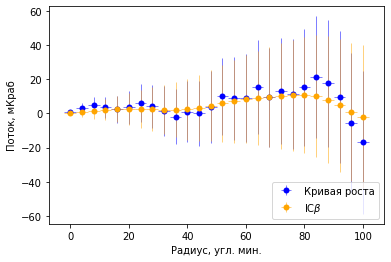

In [174]:
Inc(ResBeta3650,ResEqual3650,36,50,30,'Eq','Beta','Gauss1','Bm1')

Eq [ -0.2405038    2.0276891    2.33304833   1.49304538   4.41169694
   7.87005181   7.29848654   0.4431467    2.11626067   0.89372878
  -4.40010494  -3.24342469  -5.73078593  -8.84889474  -3.23520229
   3.39120012  -2.33441313  -6.28975294  -2.3281098   -2.29545641
  -4.25557641  -8.40459149  -9.64429967 -26.21054403  -9.92922899
   0.4939677 ]
Beta [ 0.05863905  0.47015133  1.04096194  1.5500515   2.03056846  2.41139785
  2.2046051   1.50874914  0.61063605 -0.35937318 -1.32924291 -2.08188098
 -2.94633954 -2.78537927 -2.69161068 -2.46980778 -2.72584082 -3.19914268
 -3.91567083 -4.16253428 -4.93587638 -5.99479546 -6.31928815 -5.50419078
 -2.9350214  -0.57551302]


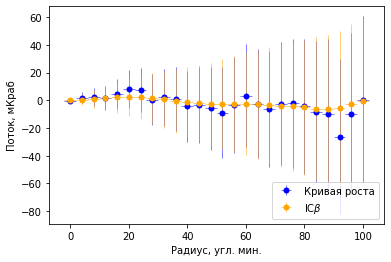

In [173]:
Inc(ResBeta50120,ResEqual50120,50,120,30,'Eq','Beta','Gauss1','Bm1')

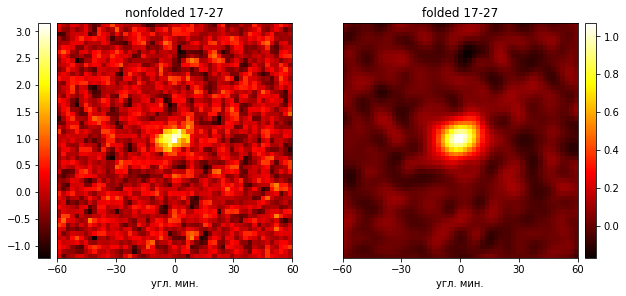

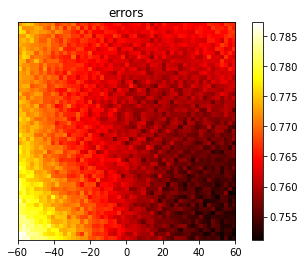

In [126]:
Im(ResEqual1727,ResBeta1727,errors1727,17,27)

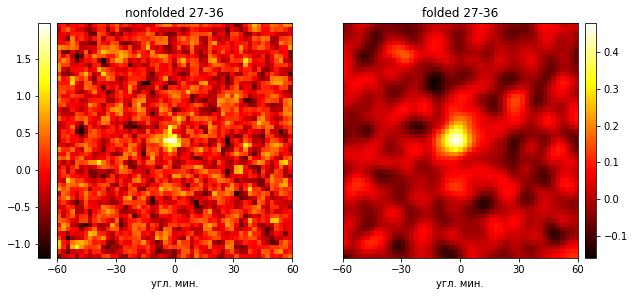

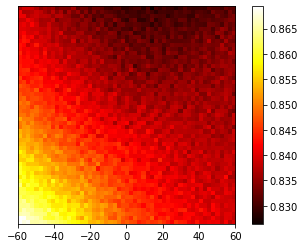

In [167]:
Im(ResEqual2736,ResBeta2736,errors2736,27,36)

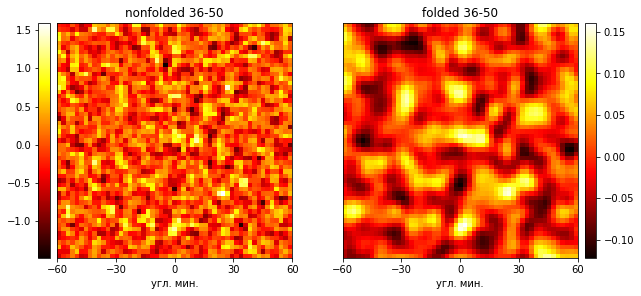

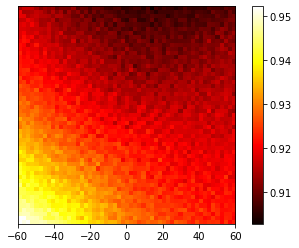

In [168]:
Im(ResEqual3650,ResBeta3650,errors3650,36,50)

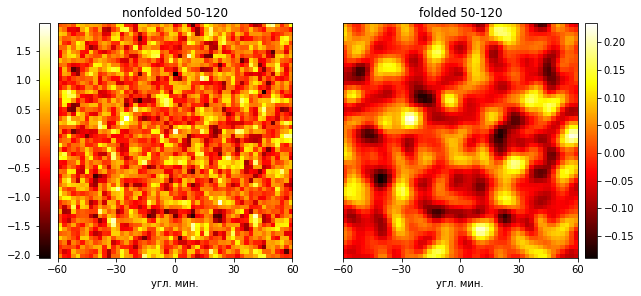

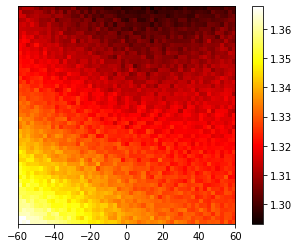

In [169]:
Im(ResEqual50120,ResBeta50120,errors50120,50,120)

In [ ]:
Im(ResEqual50120,ResBeta50120,50,120)

In [12]:
Vol=51
#Vol=7 Gauss
#Vol=5 Beta
c=(Vol-1)//2

ObjectVol=c+1

pi=3.14159265359

In [13]:
#Coma
#i_borders=(258,264)
#j_borders=(259,265)

i_center=261
j_center=262


#194.88,27.951,0.2
c1=194.88
c2=27.951
r=0.2

with fits.open('id11_Coma_mapdld _17_27.fits', mode='update') as file:
    w=wcs.WCS(file[0].header)
    pix_range=np.array([[c1,c2]],dtype=np.float32)
    border_pix=w.wcs_world2pix(pix_range,0)
j_c_coord=border_pix[0,0]
i_c_coord=border_pix[0,1]


beta=0.741
Rc=10.7/4

sigma=5/60
sigma_pix=5/4

#2.0619826+-0.35
#2.0769806083961244

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [14]:
with fits.open('id11_Coma_mapdld _17_27.fits', mode='update') as hdul:
    print(hdul[0].data[261][262])

3.1563437


In [15]:
print(i_borders,j_borders,i_center,j_center)

NameError: name 'i_borders' is not defined

In [16]:
i_borders=(i_center-ObjectVol,i_center+ObjectVol)
j_borders=(j_center-ObjectVol,j_center+ObjectVol)

In [17]:
#gaussian
def gaussian(x,y):
    return np.exp(-(x**2/(2*sigma**2)+y**2/(2*sigma**2)))/(2*pi*sigma**2)

GaussianMatr=np.zeros((Vol,Vol))
coefGauss=0;
for i in range(0,Vol):
    for j in range(0,Vol):
        value=np.exp(-((i-c)**2/(2*sigma_pix**2)+(j-c)**2/(2*sigma_pix**2)))
        GaussianMatr[i][j]=value
        coefGauss+=value
GaussianMatr/=coefGauss

In [18]:
#Beta
def BetaFunc(R):
    return (1+(R/Rc)**2)**(0.5-3*beta)

BetaMatr=np.zeros((Vol,Vol))
coefBeta=0;
for i in range(0,Vol):
    for j in range(0,Vol):
        value=BetaFunc(np.sqrt((i-c)**2+(j-c)**2))
        BetaMatr[i][j]=value
        coefBeta+=value
BetaMatr/=coefBeta

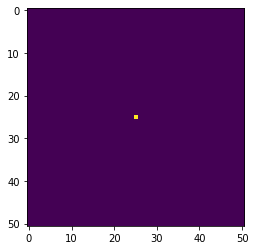

In [19]:
EqualMatr=np.zeros((Vol,Vol))
EqualMatr[c][c]=1
plt.imshow(EqualMatr)

In [20]:
def trans(i0,j0,file,Matr):
    value=0
    for i in range(i0-c,i0+c+1):
        for j in range(j0-c,j0+c+1):
            value+=file[0].data[i][j]*Matr[i-i0+c][j-j0+c]
    return value

def translation(file,Matrix):
    ResultMatrix=np.zeros((2*ObjectVol+1,2*ObjectVol+1))
    for i in range(i_borders[0],i_borders[1]+1):
        for j in range(j_borders[0],j_borders[1]+1):
            #ResultMatrix[i-i_borders[0]][j-j_borders[0]]=file[0].data[i][j]
            ResultMatrix[i-i_borders[0]][j-j_borders[0]]=trans(i,j,file,Matrix)
    #ResultMatrix*=FluxBefore/FluxAfter
    return ResultMatrix

In [21]:
def Increase_Curve(i0,j0,file,Matr):
    radial=np.zeros(c+1)
    errors=np.zeros(c+1)
    counter=np.zeros(c+1)
    pix_size=4/60
    for i in range(0,Vol):
        for j in range(0,Vol):
            distance=np.sqrt((i-c)**2+(j-c)**2)
            if(distance<c+1):
                radial[int(distance)]+=Matr[i][j]
                errors[int(distance)]+=file[1].data[i0-c+i][j0-c+j]**2
                counter[int(distance)]+=1
    for i in range(1,c+1):
        radial[i]+=radial[i-1]
        counter[i]+=counter[i-1]
        errors[i]+=errors[i-1]
    errors=np.sqrt(errors)/counter
    return radial,errors 

In [22]:
def Increase_Curve_Ob(i0,j0,file,Matr):
    radial=np.zeros(c+1)
    errors=np.zeros(c+1)
    counter=np.zeros(c+1)
    pix_size=4/60
    for i in range(0,Vol):
        for j in range(0,Vol):
            distance=np.sqrt((i-ObjectVol)**2+(j-ObjectVol)**2)
            if(distance<c+1):
                radial[int(distance)]+=Matr[i][j]
                errors[int(distance)]+=file[1].data[i0-ObjectVol+i][j0-ObjectVol+j]**2
                counter[int(distance)]+=1
    for i in range(1,c+1):
        radial[i]+=radial[i-1]
        counter[i]+=counter[i-1]
        errors[i]+=errors[i-1]
    #errors=np.sqrt(errors)/counter
    errors=np.sqrt(errors)
    return radial,errors 

In [23]:
def Increase_Curve_Matr(i0,j0,Matr):
    radial=np.zeros(c+1)
    counter=np.zeros(c+1)
    pix_size=4/60
    for i in range(0,Vol):
        for j in range(0,Vol):
            distance=np.sqrt((i-ObjectVol)**2+(j-ObjectVol)**2)
            if(distance<c+1):
                radial[int(distance)]+=Matr[i][j]
                counter[int(distance)]+=1
    for i in range(1,c+1):
        radial[i]+=radial[i-1]
        counter[i]+=counter[i-1]
    return radial

In [24]:
def Radial_prof(i0,j0,file,Matr):
    radial=np.zeros(c+1)
    errors=np.zeros(c+1)
    counter=np.zeros(c+1)
    pix_size=4/60
    for i in range(0,Vol):
        for j in range(0,Vol):
            distance=np.sqrt((i-ObjectVol)**2+(j-ObjectVol)**2)
            if(distance<c+1):
                radial[int(distance)]+=Matr[i][j]
                errors[int(distance)]+=file[1].data[i0-ObjectVol+i][j0-ObjectVol+j]**2
                counter[int(distance)]+=1
    radial=radial/counter
    errors=np.sqrt(errors)/counter
    return radial,errors 

In [25]:
print("Radial prof")
with fits.open('id11_Coma_mapdld _17_27.fits', mode='update') as hdul:
    
    radialEqual1727,errorsEqual1727 =Radial_prof(i_center,j_center,hdul,ResEqual1727)
    r4=range(0,4*len(radialEqual1727),4)
    xerr4=4*(np.ones_like(radialEqual1727))/2
    x_gaus=np.linspace(0,r4[-1],1000)
    y_gaus=np.exp(-(x_gaus**2/(2*5**2)))*radialEqual1727[0]
    y_beta=((1+(x_gaus/10.7)**2)**(-3*beta+0.5))*radialEqual1727[0]
    q=20
    plt.plot(x_gaus[0:int(q*1000/26)],y_gaus[0:int(q*1000/26)],label='PSF',color='black',linewidth=0.7,)
    #plt.plot(x_gaus,y_beta)
    plt.errorbar(r4[0:q], radialEqual1727[0:q],xerr=xerr4[0:q],yerr=errorsEqual1727[0:q],fmt='o',linewidth=0.5,mew=0,color="blue",label='Радиальный профиль')
    plt.legend(loc='upper right')
    plt.xlabel("Радиус, угл. мин.")
    plt.ylabel('Поток, мКраб')
    #plt.savefig("Radial_profile_fin.jpg",dpi=1000)
    hdul.flush()
    hdul.close()

Radial prof


NameError: name 'ResEqual1727' is not defined

In [26]:
plt.plot(y_gaus)

NameError: name 'y_gaus' is not defined

In [27]:
print("Increase curve")
with fits.open('id11_Coma_mapdld _17_27.fits', mode='update') as hdul:
    
    radialEqual1727,errorsEqual1727 =Increase_Curve_Ob(i_center,j_center,hdul,ResEqual1727)
    beta_r=Increase_Curve_Ob(i_center,j_center,hdul,ResEqual1727)
    r4=range(0,4*len(radialEqual1727),4)
    xerr4=4*(np.ones_like(radialEqual1727))/2
    
    c1=radialEqual1727[-2]/IncGauss[-2]
    c2=radialEqual1727[-2]/IncBeta[-2]
    q=30
    line1=plt.errorbar(r4[0:q], radialEqual1727[0:q],xerr=xerr4[0:q],yerr=errorsEqual1727[0:q],fmt='o',linewidth=0.5,mew=0,color="blue",label='Кривая роста')
    line2=plt.errorbar(r4, radialBeta1727,xerr=xerr4,yerr=errorsEqual1727,fmt='o',linewidth=0.5,mew=0,color="orange",label='fold')
    #line3, =plt.plot(x_gaus[0:int(q*1000/26)],IncGauss[0:int(q*1000/26)]*c1,label='PSF')
    #line4, =plt.plot(x_gaus[0:int(q*1000/26)],IncBeta[0:int(q*1000/26)]*c2,label=r'$\beta$-модель')
    plt.xlabel("Радиус, угл. мин.")
    plt.ylabel('Поток, мКраб')
    plt.legend(loc='lower right')
    #plt.gca().axis([0,80,0,90])
    #plt.savefig("Increase_curve_fin.jpg",dpi=1000)
    hdul.flush()
    hdul.close()

Increase curve


NameError: name 'ResEqual1727' is not defined

In [28]:
print("Increase curve")
with fits.open('id11_Coma_mapdld _27_36.fits', mode='update') as hdul:
    
    radialEqual1727,errorsEqual1727 =Increase_Curve_Ob(i_center,j_center,hdul,ResEqual2736)
    beta_r=Increase_Curve_Ob(i_center,j_center,hdul,ResEqual2736)
    r4=range(0,4*len(radialEqual2736),4)
    xerr4=4*(np.ones_like(radialEqual2736))/2
    
    c1=radialEqual1727[-2]/IncGauss[-2]
    c2=radialEqual1727[-2]/IncBeta[-2]
    q=30
    line1=plt.errorbar(r4[0:q], radialEqual2736[0:q],xerr=xerr4[0:q],yerr=errorsEqual2736[0:q],fmt='o',linewidth=0.5,mew=0,color="blue",label='Кривая роста')
    line2=plt.errorbar(r4, radialBeta2736,xerr=xerr4,yerr=errorsEqual2736,fmt='o',linewidth=0.5,mew=0,color="orange",label='fold')
    #line3, =plt.plot(x_gaus[0:int(q*1000/26)],IncGauss[0:int(q*1000/26)]*c1,label='PSF')
    #line4, =plt.plot(x_gaus[0:int(q*1000/26)],IncBeta[0:int(q*1000/26)]*c2,label=r'$\beta$-модель')
    plt.xlabel("Радиус, угл. мин.")
    plt.ylabel('Поток, мКраб')
    plt.legend(loc='lower right')
    #plt.gca().axis([0,80,0,90])
    #plt.savefig("Increase_curve_fin.jpg",dpi=1000)
    hdul.flush()
    hdul.close()

Increase curve


NameError: name 'ResEqual2736' is not defined

In [29]:
plt.imshow(ResEqual1727,cmap='hot',interpolation='none',extent=[-60,60,-60,60])
cbl=plt.colorbar()
cbl.set_ticks([-1,0,1,2,3])
plt.gca().get_yaxis().set_visible(False)
plt.gca().set_xticks([-60,-30,0,30, 60])
#plt.gca().get_xaxis().set_visible(False)
plt.xlabel("угл. мин.")
#plt.gca().get_yaxis().set_visible(False)
#plt.savefig("original_coma_picture.jpg",dpi=1000)

NameError: name 'ResEqual1727' is not defined

NameError: name 'ResEqual1727' is not defined

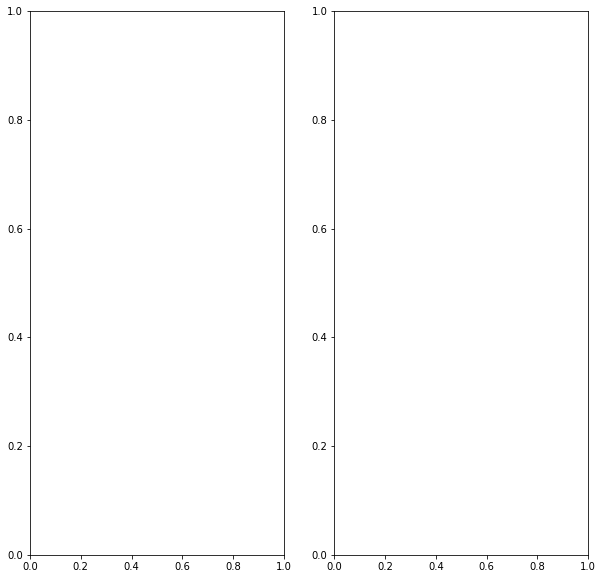

In [30]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
f,axarr=plt.subplots(1,2,figsize=(10,10))
left=axarr[0].imshow(ResEqual1727,cmap='hot',interpolation='none',extent=[-60,60,-60,60])
#f.colorbar(left)
right=axarr[1].imshow(ResBeta1727,cmap='hot',interpolation='none',extent=[-60,60,-60,60])
#f.colorbar(right)
#left=axarr[0].imshow(ResEqual1727,cmap='hot',interpolation='none',extent=[-60,60,-60,60],vmin=ResEqual1727.min(),vmax=ResEqual1727.max())
#right=axarr[1].imshow(ResBeta1727,cmap='hot',interpolation='none',extent=[-60,60,-60,60],vmin=ResEqual1727.min(),vmax=ResEqual1727.max())
#axarr[0].axes.get_xaxis().set_visible(False)
axarr[0].axes.get_yaxis().set_visible(False)
#axarr[1].axes.get_xaxis().set_visible(False)
axarr[1].axes.get_yaxis().set_visible(False)

axarr[1].axes.set_xlabel("угл. мин.")
axarr[0].axes.set_xlabel("угл. мин.")


axarr[0].set_xticks([-60,-30,0,30, 60])
axarr[1].set_xticks([-60,-30,0,30, 60])

#ax=f.gca()
divider0=make_axes_locatable(axarr[0])
divider1=make_axes_locatable(axarr[1])
cax0=divider0.append_axes("left",size="5%",pad=0.1)
cax1=divider1.append_axes("right",size="5%",pad=0.1)
cbl=f.colorbar(left,cax=cax0)
cax0.yaxis.tick_left()
cbl.set_ticks([-1,0,1,2,3])
#cbar.set_ticklabels([mn,md,mx])
cax0.set_yticks([-1, 0, 2, 3])
cbr=f.colorbar(right,cax=cax1)
cbr.set_ticks([0,0.25,0.5,0.75,1])
#plt.savefig("Coma_2_image.jpg",dpi=1000)


In [ ]:
ResEqual1727.min()

In [ ]:
ResEqual1727.max()

In [ ]:
f,axarr=plt.subplots(1,2)
left=axarr[0].imshow(ResEqual1727,cmap='hot')
right=axarr[1].imshow(ResBeta1727,cmap='hot')
axarr[0].axes.get_xaxis().set_visible(False)
axarr[0].axes.get_yaxis().set_visible(False)
axarr[1].axes.get_xaxis().set_visible(False)
axarr[1].axes.get_yaxis().set_visible(False)
#ax=f.gca()
#divider=make_axes_locatable(ax)
#cax=divider.append_axes("right",size="5%",pad=0.1)
#f.colorbar(left,cax=cax)
#plt.savefig("Coma_image.jpg",dpi=1000)

In [31]:
c1=radialBeta1727[-2]/IncGauss[-2]
c2=radialBeta1727[-1]/IncBeta[-1]
q=20
#line1=plt.errorbar(r4[0:q], radialEqual1727[0:q],xerr=xerr4[0:q],yerr=errorsEqual1727[0:q],fmt='o',linewidth=0.5,mew=0,color="blue",label='Coma')
line2=plt.errorbar(r4[0:q], radialBeta1727[0:q],xerr=xerr4[0:q],yerr=errorsEqual1727[0:q],fmt='o',linewidth=0.5,mew=0,color="orange",label='fold')
#line3, =plt.plot(x_gaus[0:int(q*1000/26)],IncGauss[0:int(q*1000/26)]*c1,label='PSF')
line4, =plt.plot(x_gaus[0:int(q*1000/34)],IncBeta[0:int(q*1000/34)]*c2,label='Бета-модель')
plt.xlabel("Радиус, угл. мин.")
plt.ylabel('Поток, мКраб')
plt.legend(loc='lower right')

NameError: name 'radialBeta1727' is not defined

In [32]:
print("Increase curve")
with fits.open('id11_Coma_mapdld _17_27.fits', mode='update') as hdul:
    
    #radialBeta1727,errorsEqual1727 =Increase_Curve_Ob(i_center,j_center,hdul,ResBeta1727)
    #beta_r=Increase_Curve_Ob(i_center,j_center,hdul,ResEqual1727)
    r4=range(0,4*len(radialBeta1727),4)
    xerr4=4*(np.ones_like(radialBeta1727))/2
    #Models
    xlist=np.linspace(0,r4[-1],100)
    #GaussPlt=[Integrate(lambda s :np.exp(-((s**2/(2*5**2)))),x)*84.21856383871636/157.07963294128714 for x in xlist]
    #BetaPlt=[Integrate(BetaFunc_ang,x)*78.24793637502053/477.99932228205574 for x in xlist]
    
    #line1=plt.errorbar(r4, radialEqual1727,xerr=xerr4,yerr=errorsEqual1727,fmt='o',linewidth=0.5,mew=0,color="blue",label='Coma')
    line2=plt.errorbar(r4[0:q], radialBeta1727[0:q],xerr=xerr4[0:q],yerr=errorsEqual1727[0:q],fmt='o',linewidth=0.5,mew=0,label='Кривая роста')
    #line3, =plt.plot(xlist,GaussPlt,label='PSF')
    line4, =plt.plot(xlist[0:76],BetaPlt[0:76],label=r'$\beta$-модель')
    plt.xlabel("Радиус, угл. мин.")
    plt.ylabel('Поток, мКраб')
    plt.legend(loc='lower right')
    #plt.gca().axis([0,80,0,90])
    #plt.savefig("Increase_curve_filtered.jpg",dpi=1000)
    hdul.flush()
    hdul.close()

Increase curve


NameError: name 'radialBeta1727' is not defined

In [33]:
len(BetaPlt)

NameError: name 'BetaPlt' is not defined

In [34]:
radialBeta1727[-1]

NameError: name 'radialBeta1727' is not defined

In [35]:
ResEqual1727.shape

NameError: name 'ResEqual1727' is not defined

In [36]:
#line1=plt.errorbar(r4, radialEqual1727,xerr=xerr4,yerr=errorsEqual1727,fmt='o',linewidth=0.5,mew=0,color="blue",label='Coma')
line2=plt.errorbar(r4, radialBeta1727,xerr=xerr4,yerr=errorsEqual1727,fmt='o',linewidth=0.5,mew=0,color="orange",label='fold')
#line3, =plt.plot(r4,GaussPlt_1*radialEqual1727[-1]/GaussPlt_1[-1],label='PSF')
line4, =plt.plot(r4,BetaPlt_1*radialEqual1727[-1]/BetaPlt_1[-1],label='Бета-модель')
plt.xlabel("Радиус, угл. мин.")
plt.ylabel('Поток, мКраб')
plt.legend(loc='lower right')

NameError: name 'r4' is not defined

In [37]:
BetaMatr_1=np.zeros((Vol,Vol))
for i in range(0,Vol):
    for j in range(0,Vol):
        value=(1+((4*(i-c))**2+(4*(j-c))**2)/10.7**2)**(-3*beta+0.5)
        BetaMatr_1[i][j]=value
GaussMatr_1=np.zeros((Vol,Vol))
for i in range(0,Vol):
    for j in range(0,Vol):
        value=np.exp(-((4*(i-c))**2+(4*(j-c))**2)/(2*5**2))
        GaussMatr_1[i][j]=value
BetaPlt_1=Increase_Curve_Matr(i_center,j_center,BetaMatr_1)
GaussPlt_1=Increase_Curve_Matr(i_center,j_center,GaussMatr_1)

In [38]:
BetaPlt_1[0]

0.6539873532843162

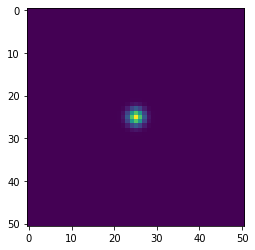

In [39]:
plt.imshow(GaussMatr_1)

In [40]:
BetaPlt_gr=[1.96098,]

In [41]:
def Integrate(f,limit):
    r=0.0005
    Int=0
    while r<limit:
        Int+=f(r)*r*0.001
        r+=0.001
    return 2*np.pi*Int